In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from xgboost import plot_importance
import matplotlib.pyplot as plt
import yfinance as yf

In [ ]:
! pip install yfinance

In [ ]:
data=yf.download('HDFCBANK.NS',start='2022-01-01',end='2023-11-02')

[*********************100%%**********************]  1 of 1 completed


In [ ]:
data.reset_index(inplace=True)

In [ ]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-01-03,1485.000000,1523.000000,1480.500000,1519.650024,1485.152466,4534592
1,2022-01-04,1520.000000,1532.900024,1507.800049,1528.550049,1493.850464,4428676
2,2022-01-05,1536.800049,1572.000000,1528.099976,1564.849976,1529.326416,7166319
3,2022-01-06,1543.000000,1554.750000,1530.050049,1539.750000,1504.796143,4814465
4,2022-01-07,1544.000000,1566.750000,1535.900024,1550.550049,1515.351074,5589692
...,...,...,...,...,...,...,...
449,2023-10-26,1491.250000,1492.000000,1460.250000,1463.400024,1463.400024,27780899
450,2023-10-27,1469.500000,1478.000000,1466.900024,1469.150024,1469.150024,15970266
451,2023-10-30,1463.250000,1489.949951,1461.900024,1485.099976,1485.099976,11655491
452,2023-10-31,1504.000000,1504.000000,1474.000000,1476.500000,1476.500000,16317412


In [ ]:
data['Moving_Average_10'] = data['Close'].rolling(window=10).mean()

In [ ]:
data

,Date,Open,High,Low,Close,Adj Close,Volume,Moving_Average_10
0,2022-01-03,1485.000000,1523.000000,1480.500000,1519.650024,1485.152466,4534592,NaN
1,2022-01-04,1520.000000,1532.900024,1507.800049,1528.550049,1493.850464,4428676,NaN
2,2022-01-05,1536.800049,1572.000000,1528.099976,1564.849976,1529.326416,7166319,NaN
3,2022-01-06,1543.000000,1554.750000,1530.050049,1539.750000,1504.796143,4814465,NaN
4,2022-01-07,1544.000000,1566.750000,1535.900024,1550.550049,1515.351074,5589692,NaN
...,...,...,...,...,...,...,...,...
449,2023-10-26,1491.250000,1492.000000,1460.250000,1463.400024,1463.400024,27780899,1517.984998
450,2023-10-27,1469.500000,1478.000000,1466.900024,1469.150024,1469.150024,15970266,1509.915002
451,2023-10-30,1463.250000,1489.949951,1461.900024,1485.099976,1485.099976,11655491,1504.850000
452,2023-10-31,1504.000000,1504.000000,1474.000000,1476.500000,1476.500000,16317412,1499.540002


In [ ]:
def compute_rsi(data, window=14):
    delta = data.diff(1)
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

data['RSI'] = compute_rsi(data['Close'], 14)

In [ ]:
data

,Date,Open,High,Low,Close,Adj Close,Volume,Moving_Average_10,RSI
0,2022-01-03,1485.000000,1523.000000,1480.500000,1519.650024,1485.152466,4534592,NaN,NaN
1,2022-01-04,1520.000000,1532.900024,1507.800049,1528.550049,1493.850464,4428676,NaN,100.000000
2,2022-01-05,1536.800049,1572.000000,1528.099976,1564.849976,1529.326416,7166319,NaN,100.000000
3,2022-01-06,1543.000000,1554.750000,1530.050049,1539.750000,1504.796143,4814465,NaN,64.295872
4,2022-01-07,1544.000000,1566.750000,1535.900024,1550.550049,1515.351074,5589692,NaN,69.050576
...,...,...,...,...,...,...,...,...,...
449,2023-10-26,1491.250000,1492.000000,1460.250000,1463.400024,1463.400024,27780899,1517.984998,29.728230
450,2023-10-27,1469.500000,1478.000000,1466.900024,1469.150024,1469.150024,15970266,1509.915002,32.219183
451,2023-10-30,1463.250000,1489.949951,1461.900024,1485.099976,1485.099976,11655491,1504.850000,41.378350
452,2023-10-31,1504.000000,1504.000000,1474.000000,1476.500000,1476.500000,16317412,1499.540002,36.617778


In [ ]:
data['Lagged_Close'] = data['Close'].shift(1)

In [ ]:
data

,Date,Open,High,Low,Close,Adj Close,Volume,Moving_Average_10,RSI,Lagged_Close
0,2022-01-03,1485.000000,1523.000000,1480.500000,1519.650024,1485.152466,4534592,NaN,NaN,NaN
1,2022-01-04,1520.000000,1532.900024,1507.800049,1528.550049,1493.850464,4428676,NaN,100.000000,1519.650024
2,2022-01-05,1536.800049,1572.000000,1528.099976,1564.849976,1529.326416,7166319,NaN,100.000000,1528.550049
3,2022-01-06,1543.000000,1554.750000,1530.050049,1539.750000,1504.796143,4814465,NaN,64.295872,1564.849976
4,2022-01-07,1544.000000,1566.750000,1535.900024,1550.550049,1515.351074,5589692,NaN,69.050576,1539.750000
...,...,...,...,...,...,...,...,...,...,...
449,2023-10-26,1491.250000,1492.000000,1460.250000,1463.400024,1463.400024,27780899,1517.984998,29.728230,1496.500000
450,2023-10-27,1469.500000,1478.000000,1466.900024,1469.150024,1469.150024,15970266,1509.915002,32.219183,1463.400024
451,2023-10-30,1463.250000,1489.949951,1461.900024,1485.099976,1485.099976,11655491,1504.850000,41.378350,1469.150024
452,2023-10-31,1504.000000,1504.000000,1474.000000,1476.500000,1476.500000,16317412,1499.540002,36.617778,1485.099976


In [ ]:
 #Bollinger Bands
data['SMA'] = data['Close'].rolling(window=20).mean()
data['Upper_Band'] = data['SMA'] + 2 * data['Close'].rolling(window=20).std()
data['Lower_Band'] = data['SMA'] - 2 * data['Close'].rolling(window=20).std()

In [ ]:
data

,Date,Open,High,Low,Close,Adj Close,Volume,Moving_Average_10,RSI,Lagged_Close,SMA,Upper_Band,Lower_Band
0,2022-01-03,1485.000000,1523.000000,1480.500000,1519.650024,1485.152466,4534592,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-04,1520.000000,1532.900024,1507.800049,1528.550049,1493.850464,4428676,NaN,100.000000,1519.650024,NaN,NaN,NaN
2,2022-01-05,1536.800049,1572.000000,1528.099976,1564.849976,1529.326416,7166319,NaN,100.000000,1528.550049,NaN,NaN,NaN
3,2022-01-06,1543.000000,1554.750000,1530.050049,1539.750000,1504.796143,4814465,NaN,64.295872,1564.849976,NaN,NaN,NaN
4,2022-01-07,1544.000000,1566.750000,1535.900024,1550.550049,1515.351074,5589692,NaN,69.050576,1539.750000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
449,2023-10-26,1491.250000,1492.000000,1460.250000,1463.400024,1463.400024,27780899,1517.984998,29.728230,1496.500000,1522.240002,1559.980558,1484.499447
450,2023-10-27,1469.500000,1478.000000,1466.900024,1469.150024,1469.150024,15970266,1509.915002,32.219183,1463.400024,1519.355005,1563.832060,1474.877950
451,2023-10-30,1463.250000,1489.949951,1461.900024,1485.099976,1485.099976,11655491,1504.850000,41.378350,1469.150024,1517.425006,1564.388644,1470.461368
452,2023-10-31,1504.000000,1504.000000,1474.000000,1476.500000,1476.500000,16317412,1499.540002,36.617778,1485.099976,1514.935004,1565.089729,1464.780279


In [ ]:
# MACD
data['ShortEMA'] = data['Close'].ewm(span=12, adjust=False).mean()
data['LongEMA'] = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = data['ShortEMA'] - data['LongEMA']
data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()

In [ ]:
data

,Date,Open,High,Low,Close,Adj Close,Volume,Moving_Average_10,RSI,Lagged_Close,SMA,Upper_Band,Lower_Band,ShortEMA,LongEMA,MACD,Signal_Line
0,2022-01-03,1485.000000,1523.000000,1480.500000,1519.650024,1485.152466,4534592,NaN,NaN,NaN,NaN,NaN,NaN,1519.650024,1519.650024,0.000000,0.000000
1,2022-01-04,1520.000000,1532.900024,1507.800049,1528.550049,1493.850464,4428676,NaN,100.000000,1519.650024,NaN,NaN,NaN,1521.019259,1520.309285,0.709973,0.141995
2,2022-01-05,1536.800049,1572.000000,1528.099976,1564.849976,1529.326416,7166319,NaN,100.000000,1528.550049,NaN,NaN,NaN,1527.762446,1523.608596,4.153850,0.944366
3,2022-01-06,1543.000000,1554.750000,1530.050049,1539.750000,1504.796143,4814465,NaN,64.295872,1564.849976,NaN,NaN,NaN,1529.606685,1524.804255,4.802430,1.715979
4,2022-01-07,1544.000000,1566.750000,1535.900024,1550.550049,1515.351074,5589692,NaN,69.050576,1539.750000,NaN,NaN,NaN,1532.828741,1526.711351,6.117390,2.596261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449,2023-10-26,1491.250000,1492.000000,1460.250000,1463.400024,1463.400024,27780899,1517.984998,29.728230,1496.500000,1522.240002,1559.980558,1484.499447,1513.088197,1533.914185,-20.825988,-17.722906
450,2023-10-27,1469.500000,1478.000000,1466.900024,1469.150024,1469.150024,15970266,1509.915002,32.219183,1463.400024,1519.355005,1563.832060,1474.877950,1506.328478,1529.116840,-22.788362,-18.735998
451,2023-10-30,1463.250000,1489.949951,1461.900024,1485.099976,1485.099976,11655491,1504.850000,41.378350,1469.150024,1517.425006,1564.388644,1470.461368,1503.062555,1525.856332,-22.793777,-19.547553
452,2023-10-31,1504.000000,1504.000000,1474.000000,1476.500000,1476.500000,16317412,1499.540002,36.617778,1485.099976,1514.935004,1565.089729,1464.780279,1498.976008,1522.200307,-23.224299,-20.282902


In [ ]:
# Stochastic Oscillator
low_min = data['Low'].rolling(window=14).min()
high_max = data['High'].rolling(window=14).max()
data['%K'] = 100 * (data['Close'] - low_min) / (high_max - low_min)
data['%D'] = data['%K'].rolling(window=3).mean()

In [ ]:
data

,Date,Open,High,Low,Close,Adj Close,Volume,Moving_Average_10,RSI,Lagged_Close,SMA,Upper_Band,Lower_Band,ShortEMA,LongEMA,MACD,Signal_Line,%K,%D
0,2022-01-03,1485.000000,1523.000000,1480.500000,1519.650024,1485.152466,4534592,NaN,NaN,NaN,NaN,NaN,NaN,1519.650024,1519.650024,0.000000,0.000000,NaN,NaN
1,2022-01-04,1520.000000,1532.900024,1507.800049,1528.550049,1493.850464,4428676,NaN,100.000000,1519.650024,NaN,NaN,NaN,1521.019259,1520.309285,0.709973,0.141995,NaN,NaN
2,2022-01-05,1536.800049,1572.000000,1528.099976,1564.849976,1529.326416,7166319,NaN,100.000000,1528.550049,NaN,NaN,NaN,1527.762446,1523.608596,4.153850,0.944366,NaN,NaN
3,2022-01-06,1543.000000,1554.750000,1530.050049,1539.750000,1504.796143,4814465,NaN,64.295872,1564.849976,NaN,NaN,NaN,1529.606685,1524.804255,4.802430,1.715979,NaN,NaN
4,2022-01-07,1544.000000,1566.750000,1535.900024,1550.550049,1515.351074,5589692,NaN,69.050576,1539.750000,NaN,NaN,NaN,1532.828741,1526.711351,6.117390,2.596261,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449,2023-10-26,1491.250000,1492.000000,1460.250000,1463.400024,1463.400024,27780899,1517.984998,29.728230,1496.500000,1522.240002,1559.980558,1484.499447,1513.088197,1533.914185,-20.825988,-17.722906,3.298455,12.138522
450,2023-10-27,1469.500000,1478.000000,1466.900024,1469.150024,1469.150024,15970266,1509.915002,32.219183,1463.400024,1519.355005,1563.832060,1474.877950,1506.328478,1529.116840,-22.788362,-18.735998,9.319397,6.823911
451,2023-10-30,1463.250000,1489.949951,1461.900024,1485.099976,1485.099976,11655491,1504.850000,41.378350,1469.150024,1517.425006,1564.388644,1470.461368,1503.062555,1525.856332,-22.793777,-19.547553,26.020917,12.879590
452,2023-10-31,1504.000000,1504.000000,1474.000000,1476.500000,1476.500000,16317412,1499.540002,36.617778,1485.099976,1514.935004,1565.089729,1464.780279,1498.976008,1522.200307,-23.224299,-20.282902,17.015707,17.452007


In [ ]:
data = data.dropna()

In [ ]:
data

,Date,Open,High,Low,Close,Adj Close,Volume,Moving_Average_10,RSI,Lagged_Close,SMA,Upper_Band,Lower_Band,ShortEMA,LongEMA,MACD,Signal_Line,%K,%D
19,2022-01-31,1472.750000,1491.550049,1466.800049,1485.699951,1451.973145,6421273,1499.839990,32.482694,1463.250000,1522.830005,1583.874559,1461.785451,1500.718291,1513.485762,-12.767470,-5.532357,35.792406,27.979735
20,2022-02-01,1508.500000,1517.000000,1473.449951,1497.000000,1463.016724,7369742,1497.389990,33.916900,1485.699951,1521.697504,1583.821326,1459.573682,1500.146247,1512.264594,-12.118348,-6.849555,43.769848,33.168591
21,2022-02-02,1511.949951,1535.000000,1505.599976,1531.199951,1496.440186,6984645,1497.584985,44.679057,1497.000000,1521.829999,1584.026617,1459.633380,1504.923740,1513.667213,-8.743474,-7.228339,79.504092,53.022115
22,2022-02-03,1528.750000,1539.949951,1509.000000,1515.349976,1480.950073,5282381,1497.274988,47.205649,1531.199951,1519.354999,1578.192423,1460.517575,1506.527776,1513.791862,-7.264086,-7.235488,66.404939,63.226293
23,2022-02-04,1528.400024,1532.849976,1514.099976,1524.000000,1489.403687,5789979,1498.774988,45.145736,1515.349976,1518.567499,1576.672610,1460.462388,1509.215810,1514.548021,-5.332210,-6.854833,73.553719,73.154250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449,2023-10-26,1491.250000,1492.000000,1460.250000,1463.400024,1463.400024,27780899,1517.984998,29.728230,1496.500000,1522.240002,1559.980558,1484.499447,1513.088197,1533.914185,-20.825988,-17.722906,3.298455,12.138522
450,2023-10-27,1469.500000,1478.000000,1466.900024,1469.150024,1469.150024,15970266,1509.915002,32.219183,1463.400024,1519.355005,1563.832060,1474.877950,1506.328478,1529.116840,-22.788362,-18.735998,9.319397,6.823911
451,2023-10-30,1463.250000,1489.949951,1461.900024,1485.099976,1485.099976,11655491,1504.850000,41.378350,1469.150024,1517.425006,1564.388644,1470.461368,1503.062555,1525.856332,-22.793777,-19.547553,26.020917,12.879590
452,2023-10-31,1504.000000,1504.000000,1474.000000,1476.500000,1476.500000,16317412,1499.540002,36.617778,1485.099976,1514.935004,1565.089729,1464.780279,1498.976008,1522.200307,-23.224299,-20.282902,17.015707,17.452007


In [ ]:
x = data[['Moving_Average_10', 'RSI', 'Lagged_Close', 'Upper_Band', 'Lower_Band', 'MACD', 'Signal_Line', '%K', '%D']]

In [ ]:
y = data['Close']

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(x):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [ ]:
model = xgb.XGBRegressor(learning_rate=0.3,max_depth=4,min_child_weight=5,n_estimators=100,subsample=1)
model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred = model.predict(x_test)

In [ ]:
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 343.41539058192734


In [ ]:
np.sqrt(mse)

18.531470275774865

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
xgb_model=xgb.XGBRegressor()
diction ={
          'max_depth':[1,2,3,4,5],'n_estimators':[10,15,20,30,40,45,50,70,80,100],'learning_rate':[0.01,0.1,0.3,0.5],'min_child_weight':[1,2,3,4,5,10,15,100],
          'subsample':[0,0.1,0.2,0.3,0.4,0.5,1]}
R_Model=RandomizedSearchCV(xgb_model,diction,
                   )
R_Model.fit(x,y)
print(R_Model.best_score_)
print(R_Model.best_params_)

0.8922991775551644
{'subsample': 0.2, 'n_estimators': 80, 'min_child_weight': 10, 'max_depth': 4, 'learning_rate': 0.1}


In [ ]:
a = R_Model.predict(x_test)

In [ ]:
mse = mean_squared_error(y_test, a)
print(f'Mean Squared Error: {mse}')
np.sqrt(mse)


Mean Squared Error: 56.778001393295


7.535117875209053

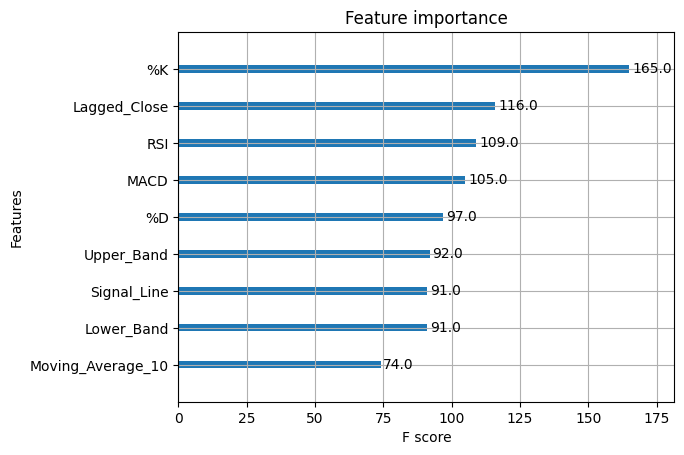

In [ ]:
plot_importance(model)
plt.show()

In [ ]:
df=pd.DataFrame(y_test)

In [ ]:
df.reset_index(inplace=True)

In [ ]:
df

,index,Close
0,382,1685.099976
1,383,1688.750000
2,384,1675.750000
3,385,1678.400024
4,386,1696.599976
...,...,...
67,449,1463.400024
68,450,1469.150024
69,451,1485.099976
70,452,1476.500000


In [ ]:
df['prediction']=y_pred.tolist()

In [ ]:
df

,index,Close,prediction
0,382,1685.099976,1678.016602
1,383,1688.750000,1674.068359
2,384,1675.750000,1674.452148
3,385,1678.400024,1680.904175
4,386,1696.599976,1713.604492
...,...,...,...
67,449,1463.400024,1449.734863
68,450,1469.150024,1423.442505
69,451,1485.099976,1472.773193
70,452,1476.500000,1441.208618


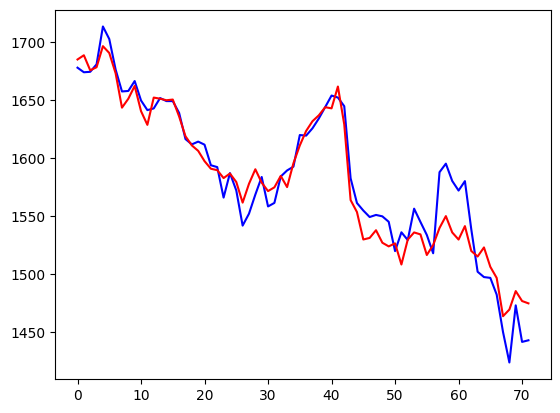

In [ ]:
plt.plot(df.prediction,color='blue')
plt.plot(df.Close,color='r')

In [ ]:
data.Close.corr(data.Moving_Average_10)

0.9483459963514411

In [ ]:
a=data.corr()
a

<ipython-input-117-14a5e97a4103>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  a=data.corr()


,Open,High,Low,Close,Adj Close,Volume,Moving_Average_10,RSI,Lagged_Close,SMA,Upper_Band,Lower_Band,ShortEMA,LongEMA,MACD,Signal_Line,%K,%D
Open,1.000000,0.993916,0.995338,0.989022,0.986568,0.313789,0.954890,0.192866,0.993214,0.915169,0.861541,0.895775,0.965269,0.928312,0.435840,0.419924,0.078280,0.121898
High,0.993916,1.000000,0.993547,0.995575,0.990954,0.330307,0.950769,0.209184,0.986700,0.910649,0.859157,0.889784,0.961503,0.923797,0.439285,0.419954,0.102346,0.131806
Low,0.995338,0.993547,1.000000,0.995480,0.994118,0.302842,0.952179,0.204883,0.989455,0.913251,0.854003,0.898690,0.963507,0.925642,0.440665,0.422914,0.107811,0.132469
Close,0.989022,0.995575,0.995480,1.000000,0.996322,0.309805,0.948346,0.219282,0.981782,0.909582,0.853726,0.892443,0.959852,0.921912,0.440258,0.421089,0.131533,0.139392
Adj Close,0.986568,0.990954,0.994118,0.996322,1.000000,0.331608,0.949463,0.199325,0.979339,0.913979,0.849486,0.903756,0.961240,0.927493,0.416383,0.398757,0.108887,0.115757
Volume,0.313789,0.330307,0.302842,0.309805,0.331608,1.000000,0.355585,-0.096197,0.313744,0.371680,0.412188,0.311707,0.357278,0.392690,-0.121906,-0.123385,-0.229709,-0.199376
Moving_Average_10,0.954890,0.950769,0.952179,0.948346,0.949463,0.355585,1.000000,0.032445,0.961953,0.975143,0.922395,0.950802,0.996594,0.977999,0.337123,0.412955,-0.133029,-0.096207
RSI,0.192866,0.209184,0.204883,0.219282,0.199325,-0.096197,0.032445,1.000000,0.178608,-0.147126,-0.161048,-0.125153,0.016720,-0.107998,0.723406,0.488514,0.783068,0.838099
Lagged_Close,0.993214,0.986700,0.989455,0.981782,0.979339,0.313744,0.961953,0.178608,1.000000,0.921470,0.866646,0.902632,0.970703,0.933017,0.441298,0.434148,0.049669,0.112285
SMA,0.915169,0.910649,0.913251,0.909582,0.913979,0.371680,0.975143,-0.147126,0.921470,1.000000,0.954144,0.968149,0.982597,0.994318,0.158990,0.268916,-0.230784,-0.225202


<Axes: >

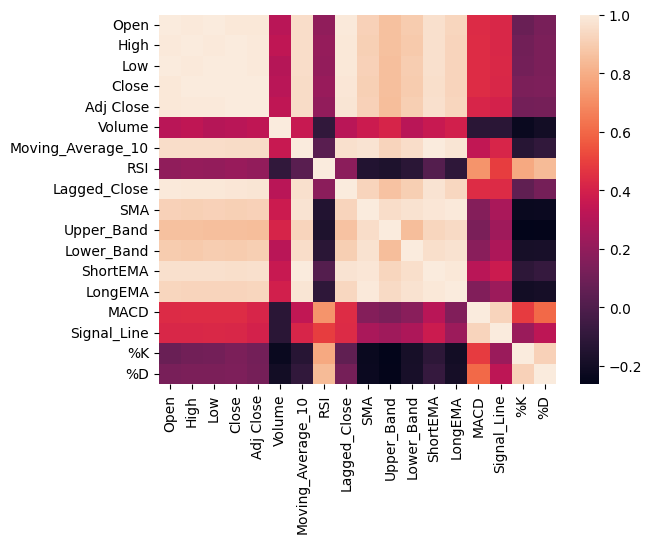

In [ ]:
import seaborn as sns
sns.heatmap(a)

In [ ]:
fixed_variable=data['Close']


In [ ]:
other_variable=data[['Moving_Average_10', 'RSI', 'Lagged_Close', 'Upper_Band', 'Lower_Band', 'MACD', 'Signal_Line', '%K', '%D']]

In [ ]:
for i in other_variable:
  corelation=fixed_variable.corr(data[i])
  print(corelation)

0.9483459963514411
0.21928198310798622
0.9817820440990236
0.8537259221252395
0.8924432589414756
0.4402580384811374
0.4210889694531242
0.13153258087038183
0.13939204144488587


In [ ]:
g

%D
